**Architecture**

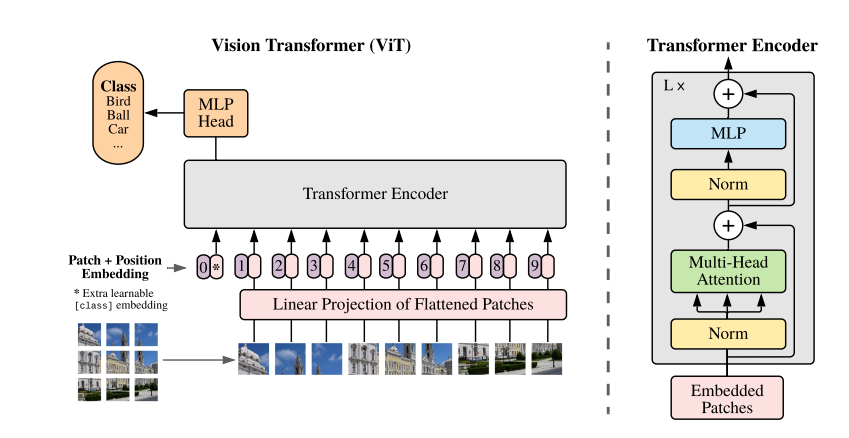

**Four equations**

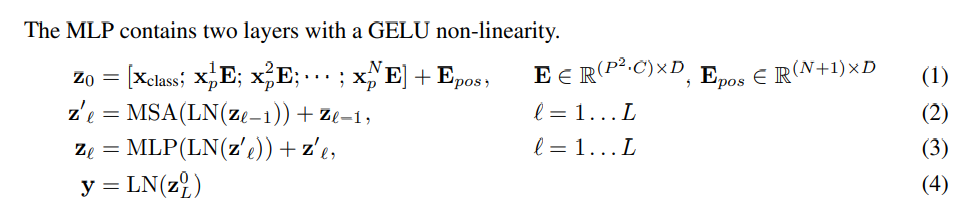

**0. Import important liberaries**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

**1. image to patches**

Training resolution is 224.

In [18]:
image=Image.open('alihassan.png').resize((224,224))
x=np.array(image)
P=16
C=3

patches=x.reshape(x.shape[0] //P ,P,x.shape[1] // P,P,C).swapaxes(1,2).reshape(-1,P,P,C)
x_p=np.reshape(patches,(-1,P*P*C))
N=x_p.shape[0]
N

196

**2.embeddings of patches**

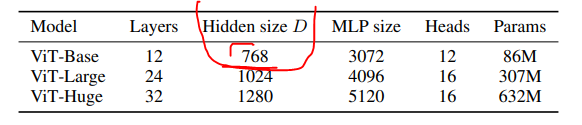

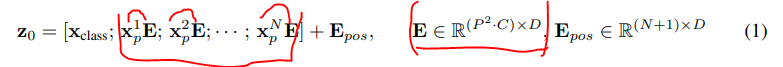

In [19]:
D=768
B=1
x_p=torch.Tensor(x_p)
x_p=x_p[None,...]
E=nn.Parameter(torch.randn(B,P*P*C,D))
patch_embeddings=torch.matmul(x_p,E)
patch_embeddings.shape

torch.Size([1, 196, 768])

**3. CLASS TOKEN**

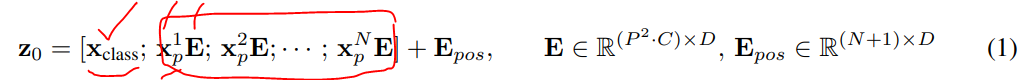

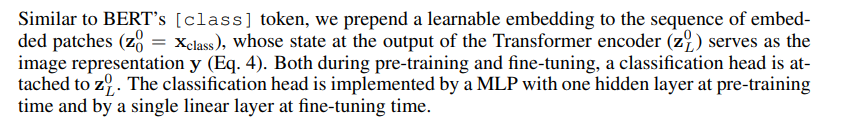

In [20]:
class_token=nn.Parameter(torch.randn(B,1,D))
class_token.shape

torch.Size([1, 1, 768])

In [21]:
patch_embeddings=torch.cat((class_token,patch_embeddings),1)
patch_embeddings.shape

torch.Size([1, 197, 768])

**4.Positional Information**

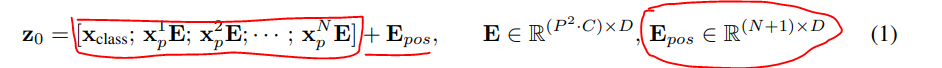

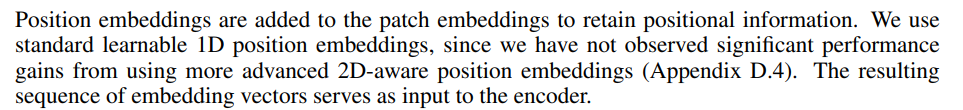

In [22]:
E_pos=nn.Parameter(torch.randn(B,N + 1,D))
E_pos.shape

torch.Size([1, 197, 768])

In [23]:
z0=patch_embeddings + E_pos
z0.shape

torch.Size([1, 197, 768])

**5.Self attention**

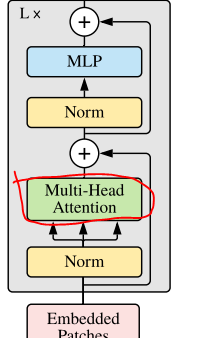

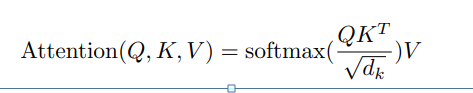

In [24]:
class SelfAttention(nn.Module):
  def __init__(self,embedding_dim=768,key_dim=64):
    super().__init__()
    self.embedding_dim=embedding_dim
    self.key_dim=key_dim
    self.W=nn.Parameter(torch.randn(embedding_dim,3 * key_dim))
  def forward(self,x):
    key_dim=self.key_dim
    qkv=torch.matmul(x,self.W)
    q=qkv[:,:,:key_dim]
    k=qkv[:,:,key_dim:key_dim*2 ]
    v=qkv[:,:,key_dim*2:]
    k_T=torch.transpose(k,-2,-1)
    dot_products=torch.matmul(q,k_T)
    scaled_dot_products=dot_products / np.sqrt(key_dim)
    attention_weights=F.softmax(scaled_dot_products,dim=1)
    weighted_values=torch.matmul(attention_weights,v)
    return weighted_values

In [25]:
D_h=64
self_attention=SelfAttention(D,D_h)
attention_scores=self_attention(patch_embeddings)
attention_scores.shape

torch.Size([1, 197, 64])

**6.Multi head attention**

In [26]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self,embedding_dim=768,num_heads=12):
    super().__init__()
    self.embeddding_dim=embedding_dim
    self.num_heads=num_heads
    assert embedding_dim % num_heads == 0  #768 % 12
    self.key_dim=embedding_dim // num_heads
    self.attention_list=[SelfAttention(embedding_dim,self.key_dim) for _ in range(num_heads)]
    self.multihead_attention=nn.ModuleList(self.attention_list)
    self.W=nn.Parameter(torch.randn(num_heads * self.key_dim,embedding_dim))
  def forward(self,x):
    attention_scores=[ attention(x) for attention in self.multihead_attention]
    Z=torch.cat(attention_scores,-1)
    attention_score=torch.matmul(Z,self.W)
    return attention_score


In [27]:
n_head=12
multi_head_attention=MultiHeadSelfAttention(D,n_head)
attention_score=multi_head_attention(patch_embeddings)
attention_score.shape

torch.Size([1, 197, 768])

**7.Multi Layer perceptron**

The MLP contains two layers with a GELU non-linearity

3072

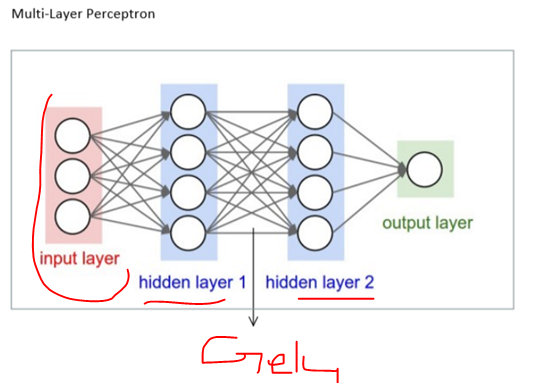

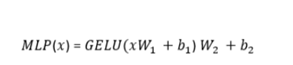

In [28]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self,embedding_dim=768,hidden_dim=3072):
    super().__init__()
    self.mlp=nn.Sequential(
                        nn.Linear(embedding_dim,hidden_dim),
                        nn.GELU(),
                        nn.Linear(hidden_dim,embedding_dim)

                      )
  def forward(self,x):
    x=self.mlp(x)
    return x

In [29]:
hidden_dim=3072
mlp=MultiLayerPerceptron(D,hidden_dim)
output=mlp(patch_embeddings)
output.shape

torch.Size([1, 197, 768])

**8.Layer Norm**

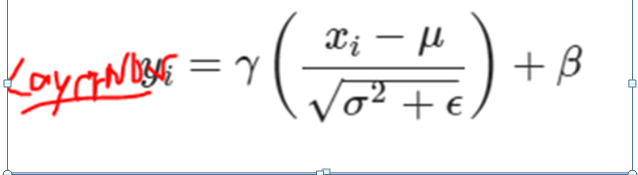

In [30]:
class LayerNormalization(nn.Module):
  def __init__(self,eps:float=10**6) -> None:
    super().__init__()
    self.eps=eps
    self.alpha=nn.Parameter(torch.ones(1))
    self.bias=nn.Parameter(torch.zeros(1))
  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    std=x.std(dim=-1,keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

**9.Transformer Encoder**

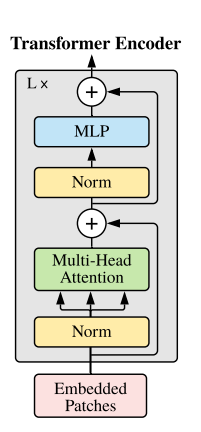

In [31]:
class TransformerEncoder(nn.Module):
  def __init__(self,embedding_dim=768,num_heads=12,hidden_dim=3072,dropout_prob=0.1):
    super().__init__()
    self.MSA=MultiHeadSelfAttention(embedding_dim,num_heads)
    self.MLP=MultiLayerPerceptron(embedding_dim,hidden_dim)
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.layer_norm2=nn.LayerNorm(embedding_dim)
    self.dropout1=nn.Dropout(p=dropout_prob)
    self.dropout2=nn.Dropout(p=dropout_prob)
    self.dropout3=nn.Dropout(p=dropout_prob)
  def forward(self,x):
    out_1=self.dropout1(x)
    out_2=self.layer_norm1(out_1)
    msa_out=self.MSA(out_2)
    out_3=self.dropout2(msa_out)
    res_out=x +  out_3
    out_4=self.layer_norm2(res_out)
    mlp_out=self.MLP(out_4)
    out_5=self.dropout3(mlp_out)
    output=res_out + out_5
    return output

In [32]:
dropout_prob=0.1
transformer_encoder=TransformerEncoder(D,n_head,hidden_dim,dropout_prob)

output=transformer_encoder(patch_embeddings)

In [33]:
output.shape

torch.Size([1, 197, 768])

In [34]:
output[0][0].shape

torch.Size([768])

**10.MLP Head (classification head)**

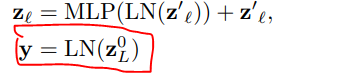

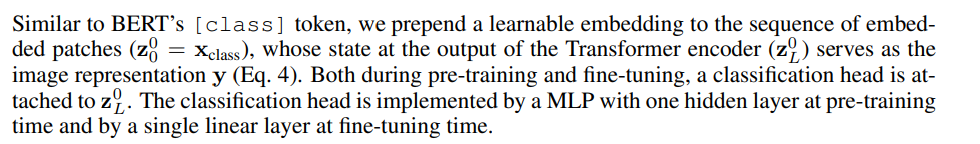

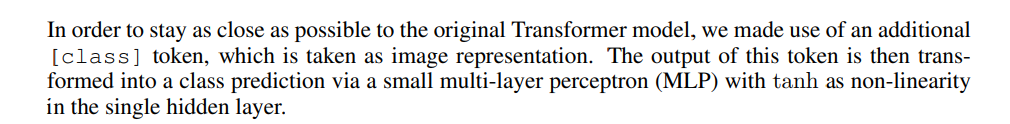

In [35]:
class MLPHead(nn.Module):
  def __init__(self,embedding_dim=768,num_classes=10,fine_tune=False):
    super().__init__()
    self.num_classes=num_classes
    if not fine_tune:
      self.mlp_head=nn.Sequential(
                        nn.Linear(embedding_dim,3072),
                        nn.Tanh(),
                        nn.Linear(3072,num_classes)

      )
    else:
      self.mlp_head=nn.Linear(embedding_dim,num_classes)
  def forward(self,x):
    x=self.mlp_head(x)
    return x

**11.Vison transformer**

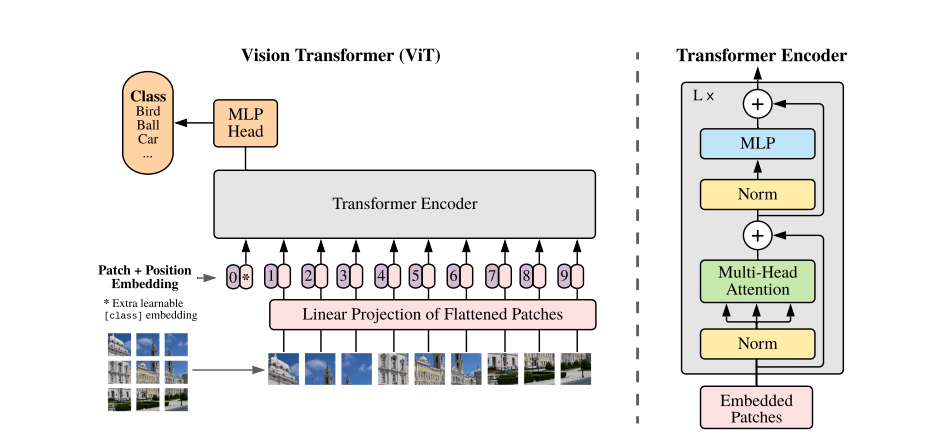

In [36]:

class VisionTransformer(nn.Module):
  def __init__(self,patch_size=16,image_size=224,channel_size=3,num_layers=12,embedding_dim=768,num_heads=12,
               hidden_dim=3072,dropout_prob=0.1,num_classes=10,pretrain=True):
    super().__init__()
    self.patch_size=patch_size
    self.channel_size=channel_size
    self.num_layers=num_layers
    self.embedding_dim=embedding_dim
    self.num_heads=num_heads
    self.hidden_dim=hidden_dim
    self.dropout_prob=dropout_prob
    self.num_classes=num_classes

    self.num_patches=int(image_size**2 / patch_size**2)
    self.W=nn.Parameter(torch.randn(patch_size *patch_size *channel_size,embedding_dim))
    self.pos_embedding=nn.Parameter(torch.randn(self.num_patches + 1,embedding_dim))
    self.class_token=nn.Parameter(torch.randn(1,D))

    transformer_encoder_list=[
        TransformerEncoder(embedding_dim,num_heads,hidden_dim,dropout_prob)
        for _ in range(num_layers)
    ]
    self.transformer_encoder_layers=nn.Sequential(*transformer_encoder_list)
    self.mlp_head=MLPHead(embedding_dim,num_classes)

  def forward(self,x):
    P,C=self.patch_size,self.channel_size
    #[batch_size,channels,hight,width]
    patches=x.unfold(1,C,C).unfold(2,P,P).unfold(3,P,P)
    patches=patches.contiguous().view(patches.size(0),-1,C*P*P).float()

    patch_embeddings=torch.matmul(patches,self.W)

    batch_size=patch_embeddings.shape[0]
    patch_embeddings=torch.cat((self.class_token.repeat(batch_size,1,1),patch_embeddings),1)

    patch_embeddings=patch_embeddings + self.pos_embedding
    transformer_encoder_output=self.transformer_encoder_layers(patch_embeddings)
    output_class_token=transformer_encoder_output[:,0]
    y=self.mlp_head(output_class_token)
    return y

In [37]:
image_size=224; channel_size=3
n_class=10
dropout_prob=0.1
n_layer=12; embedding_dim=768;n_head=12; hidden_dim=3072
image=Image.open('alihassan.png').resize((image_size,image_size))
x=T.PILToTensor()(image)
x=x[None,...]
patch_size=16
vision_transformer=VisionTransformer(patch_size,image_size,channel_size,n_layer,embedding_dim,n_head,hidden_dim,dropout_prob,n_class)
vit_output=vision_transformer(x)
vit_output.shape

torch.Size([1, 10])

In [38]:
vit_output

tensor([[ 0.1444,  0.1579, -0.6368,  0.3207,  0.4885, -1.0140,  0.6764,  0.0090,
         -0.1341,  0.0069]], grad_fn=<AddmmBackward0>)

In [39]:
probabilities=F.softmax(vit_output[0],dim=0)
probabilities

tensor([0.1042, 0.1057, 0.0477, 0.1243, 0.1471, 0.0327, 0.1775, 0.0910, 0.0789,
        0.0909], grad_fn=<SoftmaxBackward0>)

In [40]:
print(torch.sum(probabilities))

tensor(1., grad_fn=<SumBackward0>)
